<a href="https://colab.research.google.com/github/stikoson/datasharing/blob/master/bert_multiclass_text_classification_by_fine_tuning__20newsgroups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Multi-class Text Classification Using BERT-Fine-Tuning (20-Newsgroup)**

**Detailed Article**: https://pysnacks.com/bert-text-classification-with-fine-tuning

In [ ]:
#@title Install libraries
!pip install -q keras-bert keras-rectified-adam
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
#@title Set environment variables
import os
import contextlib
import tensorflow as tf

USE_TPU = False
os.environ['TF_KERAS'] = '1'

# @title Initialize TPU Strategy
if USE_TPU:
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)
  tf.contrib.distribute.initialize_tpu_system(resolver)
  strategy = tf.contrib.distribute.TPUStrategy(resolver)

import os
import codecs
import numpy as np
from tqdm import tqdm

# Tensorflow Imports
import tensorflow as tf
from tensorflow.python import keras
import tensorflow.keras.backend as K

# Keras-bert imports
from keras_radam import RAdam
from keras_bert import Tokenizer
from keras_bert import get_custom_objects
from keras_bert import load_trained_model_from_checkpoint

os.environ['TF_KERAS'] = '1'

In [ ]:
# @title Download models and data
!wget -q https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip -o uncased_L-12_H-768_A-12.zip

dataset = tf.keras.utils.get_file(
    fname="20news-18828.tar.gz", 
    origin="http://qwone.com/~jason/20Newsgroups/20news-18828.tar.gz", 
    extract=True,
)

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  
14671872/14666916 [==============================] - 4s 0us/step


In [ ]:
#@title Prepare training and test data

# Bert Model Constants
SEQ_LEN = 128
BATCH_SIZE = 16
EPOCHS = 4
LR = 2e-5

pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

tokenizer = Tokenizer(token_dict)

def load_data(path, tagset):
    """
    Input:
      path: Root directory where the categorical data sit in folders.
      tagset: List of folder-name, category tuples.
    Output:
      train_x / test_x: List with two items (viz token_input, seg_input)
      test_x / test_y: Output labels corresponding to trainx / train_y.
    """
    global tokenizer
    indices, labels = [], []
    for folder, label in tagset:
        folder = os.path.join(path, folder)
        for name in tqdm(os.listdir(folder)):
            with open(os.path.join(folder, name), 'r', encoding="utf-8", errors='ignore') as reader:
                  text = reader.read()
            ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
            indices.append(ids)
            labels.append(label)
  
    items = list(zip(indices, labels))
    np.random.shuffle(items)
    indices, labels = zip(*items)
    indices = np.array(indices)
    mod = indices.shape[0] % BATCH_SIZE
    if mod > 0:
        indices, labels = indices[:-mod], labels[:-mod]
    return [indices, np.zeros_like(indices)], np.array(labels)


path = os.path.join(os.path.dirname(dataset), '20news-18828')
tagset = [(x, i) for i,x in enumerate(os.listdir(path))]
id_to_labels = {id_: label for label, id_ in tagset}

# Load data, split 80-20 for triaing/testing.
all_x, all_y = load_data(path, tagset)

train_perc = 0.8
total = len(all_y)

n_train = int(train_perc * total)
n_test = (total - n_train)

test_x = [all_x[0][n_train:], all_x[1][n_train:]]
train_x = [all_x[0][:n_train], all_x[1][:n_train]]

train_y, test_y = all_y[:n_train], all_y[n_train:]

print("# Total: %s, # Train: %s, # Test: %s" % (total, n_train, n_test))

100%|██████████| 910/910 [00:03<00:00, 233.23it/s]


# Total: 18816, # Train: 15052, # Test: 3764


In [ ]:
# @title Build Custom (Fine-Tuned) Model 

# Load pretrained model
with strategy.scope() if USE_TPU else contextlib.suppress():
  model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,
  )
  
  # Add dense layer for classification
  inputs = model.inputs[:2]
  dense = model.get_layer('NSP-Dense').output
  outputs = keras.layers.Dense(units=20, activation='softmax')(dense)
  model = keras.models.Model(inputs, outputs)

  model.compile(
      RAdam(lr=LR),
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'],
  )

print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 128)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 23440896    Input-Token[0][0]                
___________________________________________________________________________________________

In [ ]:
# @title Initialize Variables

sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables]
)
sess.run(init_op)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# @title Train
history = model.fit(
    train_x,
    train_y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.20,
    shuffle=True,
)
#model.save('20_newsgroups.h5')

Train on 12041 samples, validate on 3011 samples
Epoch 1/4
12041/12041 [==============================] - 765s 64ms/sample - loss: 1.6826 - sparse_categorical_accuracy: 0.5052 - val_loss: 0.6773 - val_sparse_categorical_accuracy: 0.7948
Epoch 2/4
12041/12041 [==============================] - 749s 62ms/sample - loss: 0.4951 - sparse_categorical_accuracy: 0.8481 - val_loss: 0.4421 - val_sparse_categorical_accuracy: 0.8698
Epoch 3/4
12041/12041 [==============================] - 748s 62ms/sample - loss: 0.2534 - sparse_categorical_accuracy: 0.9239 - val_loss: 0.3752 - val_sparse_categorical_accuracy: 0.8947
Epoch 4/4
12041/12041 [==============================] - 746s 62ms/sample - loss: 0.1386 - sparse_categorical_accuracy: 0.9588 - val_loss: 0.3471 - val_sparse_categorical_accuracy: 0.9083


dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


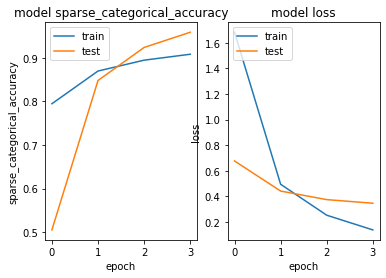

In [ ]:
#@title Plot model training progress
#@markdown The model starts over-fitting after 3rd epoch

import matplotlib.pyplot as plt
import numpy
%matplotlib inline

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('model sparse_categorical_accuracy')
plt.ylabel('sparse_categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1, 2, 2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
#@title Get test set predictions.
predicts = model.predict(test_x, verbose=True).argmax(axis=-1)

3764/3764 [==============================] - 58s 16ms/sample


Accuracy: 0.9024973432518597
macro_f1: 0.9001928370898599
micro_f1:0.9024973432518597
weighted_f1:0.903511748879483


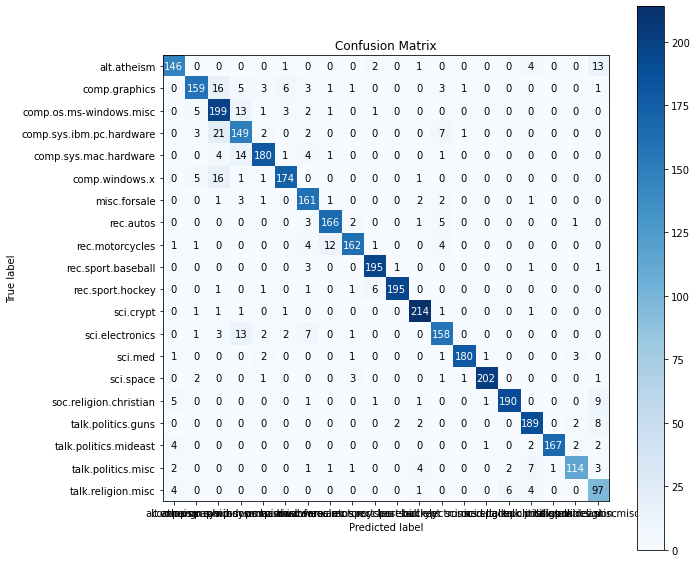

In [ ]:
#@title Evaluate Model Accuracy and F1 Score
#@markdown Accuracy: 90.2%, F1-Score: 0.9

! pip install -q scikit-plot
import scikitplot as skplt
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(test_y, predicts)
macro_f1 = f1_score(test_y, predicts, average='macro')
micro_f1 = f1_score(test_y, predicts, average='micro')
weighted_f1 = f1_score(test_y, predicts, average='weighted')

print("Accuracy: %s" % accuracy)
print ('macro_f1: %s\nmicro_f1:%s\nweighted_f1:%s' %(
    macro_f1, micro_f1, weighted_f1)
)

skplt.metrics.plot_confusion_matrix(
    [id_to_labels[x] for x in test_y], 
    [id_to_labels[x] for x in predicts],
    figsize=(10,10))

In [ ]:
#@title Classifying texts
texts = [
  'Who scored the maximum goals?',
  'Mars might have water and dragons!',
  'CPU is over-clocked, causing it to heating too much!',
  'I need to buy new prescriptions.',
  'This is just government propaganda.'
]
for text in texts:
  ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
  inpu = np.array(ids).reshape([1, SEQ_LEN])
  predicted_id = model.predict([inpu,np.zeros_like(inpu)]).argmax(axis=-1)[0]
  print ("%s: %s"% (id_to_labels[predicted_id], text))


rec.sport.hockey: Who scored the maximum goals?
sci.space: Mars might have water and dragons!
comp.sys.ibm.pc.hardware: CPU is over-clocked, causing it to heating too much!
sci.med: I need to buy new prescriptions.
talk.politics.misc: This is just government propaganda.
